In [1]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
import pprint

import multiprocessing as mp
import concurrent

from utils import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# fit pwm5
- learning rate and critic loss weight

## notes
- PWM0: is the trivial task implementation
    - two stim, response given by second
- PWM5: is closer to real PWM
    - 5 stimuli (ABCDE) 
    - A&E are edge cases where response given by second stim
    - others require comparison

In [2]:
EPLEN = 15

def seed_exp(seed,args):
  """ loss [(value, policy),neps] """
  neps = args['task']['neps']
  # task and agent definition
  agent_kw = args['agent']
  agent = ActorCritic(**agent_kw)
  task_kw = {'stimset':'pwm5','epoch_len':EPLEN,'trlen':3}
  task = PWMTaskFR(**task_kw)
  # init loop vars
  reward = -np.ones(neps)
  loss = -np.ones([2,neps])
  pism = -np.ones([3,neps])
  L = []
  # loop over epochs
  for epoch in range(neps):
    epoch_data = run_epoch_FR(agent,task)
    epoch_data = process_epdata(epoch_data)
    update_data = agent.update(epoch_data)
    reward[epoch] = np.sum(epoch_data['reward'])/task.ntrials
    loss[:,epoch] = list(update_data.values())
  data = {'loss':loss,'reward':reward}
  return data

In [3]:
# common setup
ns,neps = 3,10000
args = {
  'task':{
    'neps':neps
  },
  'agent':{
    'gamma':1.0,
    'learnrate':0.005,
    'lweight':None # gridsearch
  }
}

# gridsearch loss weight
lwL = [2,3,4,5]
lossL = np.zeros([len(lwL),2,neps])
rewardL = np.zeros([len(lwL),neps])

for idx in range(len(lwL)):
  print(lwL[idx])
  args['agent']['lweight'] = lwL[idx]
  dataL = exp_mp(seed_exp,nseeds=ns,gsvar=args)
  # unpack
  lossL[idx] = np.array([d['loss'] for d in dataL]).mean(0) # mean over seeds
  rewardL[idx] = np.array([d['reward'] for d in dataL]).mean(0)

2
3
4
5


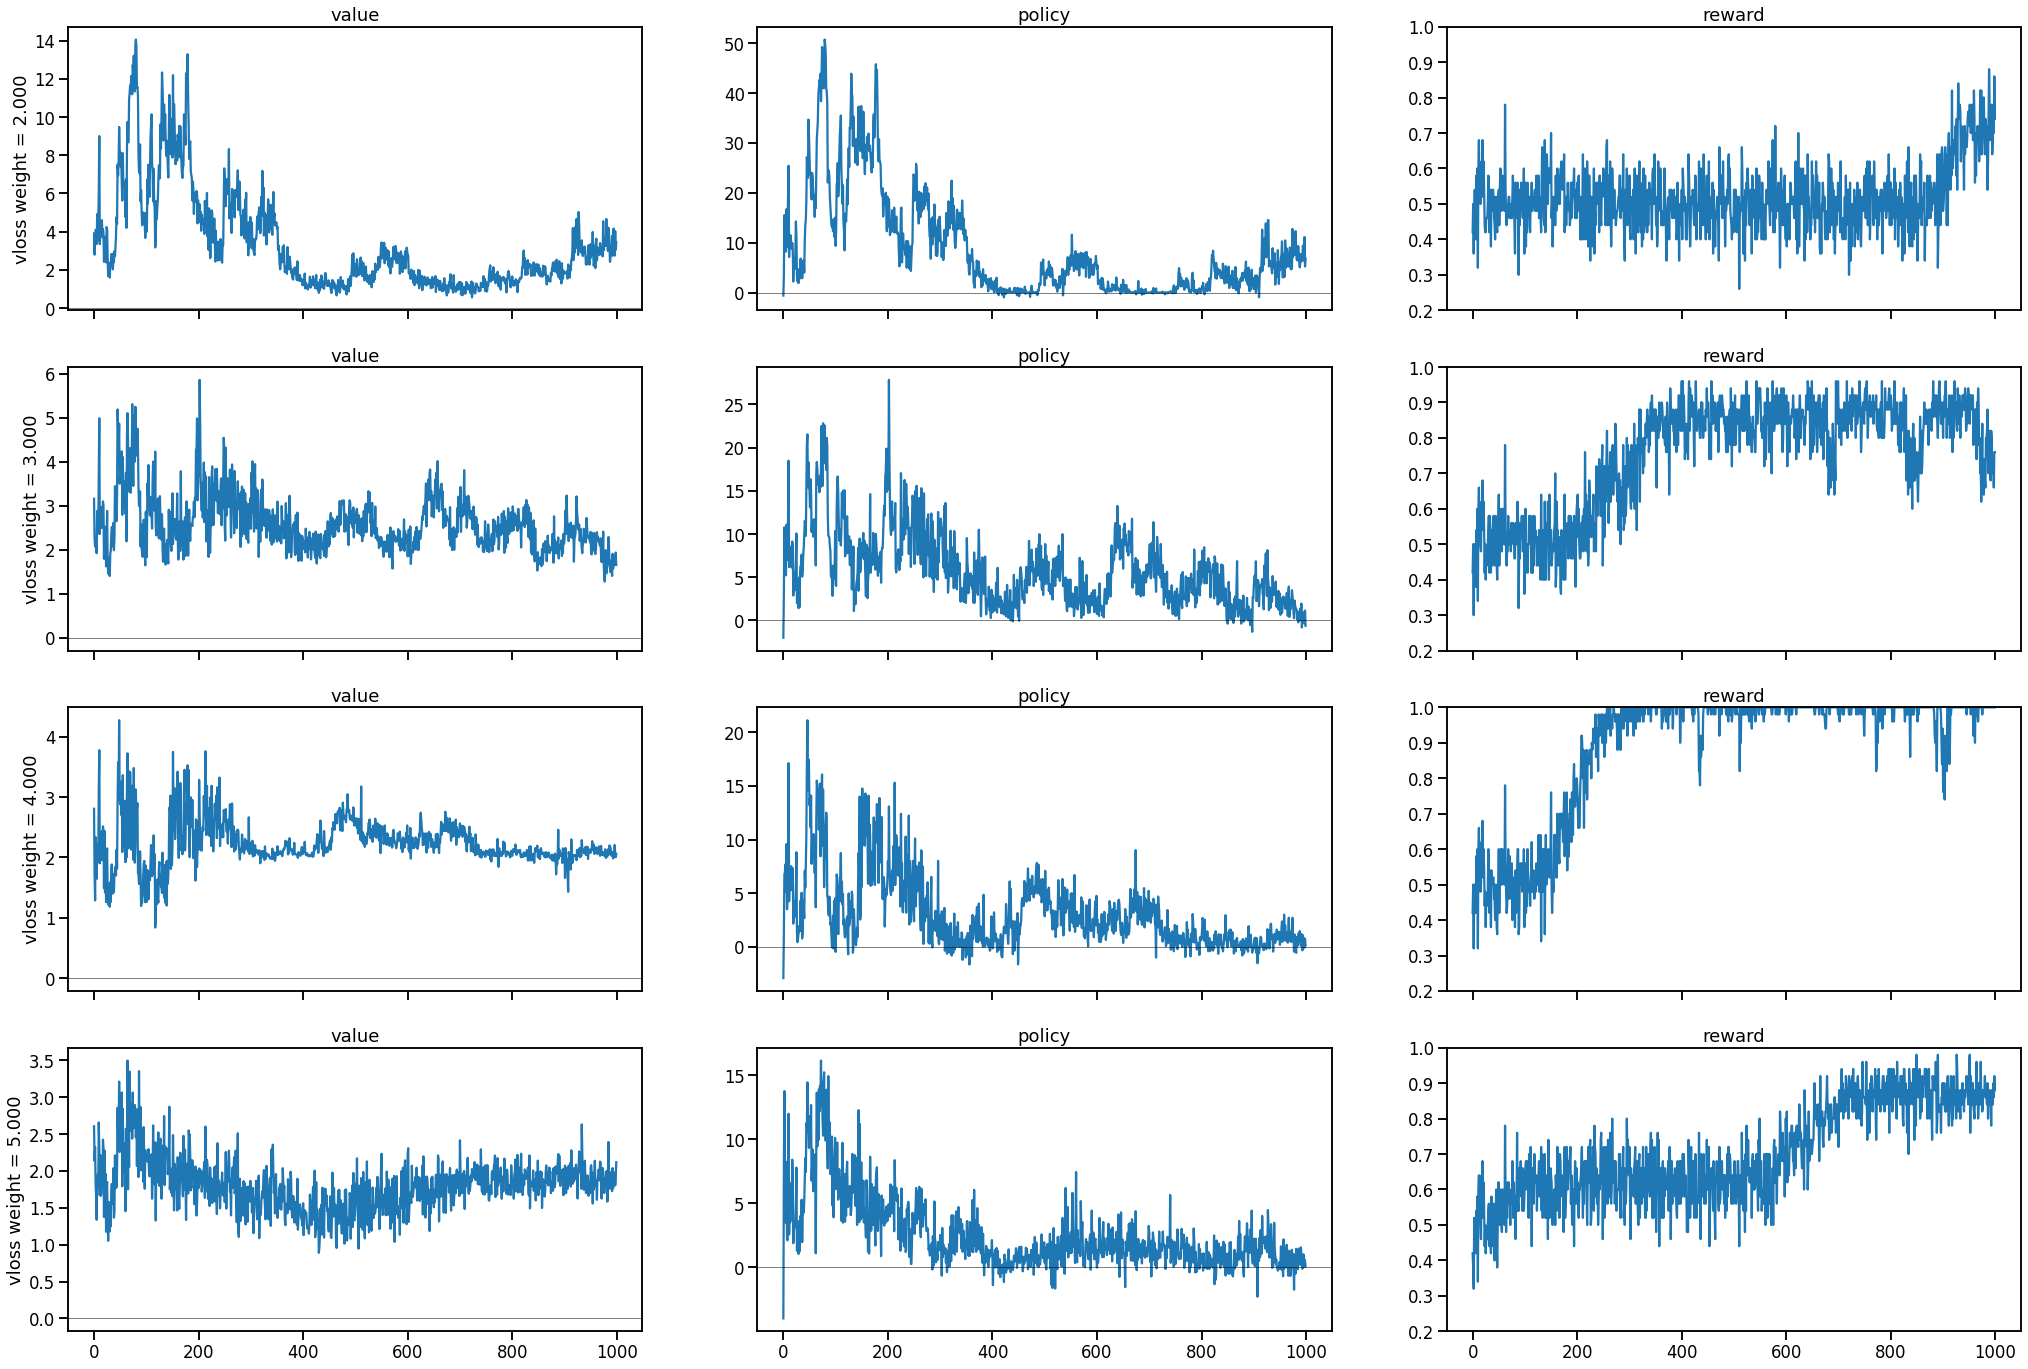

In [5]:
# PLT GRIDSEARCH (loss and reward)
f,axar = plt.subplots(len(lossL),3,figsize=(35,24),sharex=True)
ma_win = 10
labL = ['value','policy']
for li in range(len(lossL)):
  loss = lossL[li]
  axa = axar[li]
  axa[0].set_ylabel('vloss weight = %.3f'%lwL[li])
  for i in range(2):
    ax = axa[i]
    ax.set_title(labL[i])
    ax.plot(loss[i].reshape(-1,ma_win).mean(-1))
    ax.axhline(0,c='k',lw=0.5)
  ax = axa[2]
  ax.plot(rewardL[li].reshape(-1,ma_win).mean(-1))
  ax.set_title('reward')
  ax.set_ylim(0.2,1)
plt.savefig('figures/pwm5-eplen15-vweight_loss-REINFORCE-lrate_%.4f-3seed.png'%0.005)